<a href="https://colab.research.google.com/github/LukmanovaLiliya/-/blob/main/Lukmanova_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install xgboost
!pip install lightgbm
!pip install catboost

In [2]:
import numpy as np 
import pandas as pd 


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
import catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
TRAIN_DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/course_project_2/course_project_train.csv'
TEST_DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/course_project_2/course_project_test.csv'
SUBMIT_DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/course_project_2/Lukmanova_predictions.csv'

df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)
submit = pd.read_csv(SUBMIT_DATASET_PATH)
df_train.shape, df_test.shape

((7500, 17), (2500, 16))

In [4]:
target_name = 'Credit Default'
cat_feature_names = [col for col in df_train.drop(target_name, axis=1).columns \
                     if len(df_train[col].unique()) < 16] 
print(f'Категориальные признаки: {cat_feature_names}')
num_feature_names = [col for col in df_train.drop(target_name, axis=1).columns \
                     if col not in cat_feature_names]
print(f'Количественные признаки: {num_feature_names}')
selected_features = cat_feature_names + num_feature_names
print(f'Число признаков - {len(selected_features)}')

Категориальные признаки: ['Home Ownership', 'Years in current job', 'Tax Liens', 'Number of Credit Problems', 'Bankruptcies', 'Purpose', 'Term']
Количественные признаки: ['Annual Income', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Months since last delinquent', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']
Число признаков - 16


In [5]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.tail()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
7495,Rent,402192.0,< 1 year,0.0,3.0,8.5,107866.0,0.0,NaN,0.0,other,Short Term,129360.0,73492.0,1900.0,697.0,0
7496,Home Mortgage,1533984.0,1 year,0.0,10.0,26.5,686312.0,0.0,43.0,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,7410.0,1
7497,Rent,1878910.0,6 years,0.0,12.0,32.1,1778920.0,0.0,NaN,0.0,buy a car,Short Term,99999999.0,477812.0,12479.0,748.0,0
7498,Home Mortgage,NaN,NaN,0.0,21.0,26.5,1141250.0,0.0,NaN,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,NaN,0
7499,Rent,NaN,4 years,0.0,8.0,9.4,480832.0,0.0,NaN,0.0,debt consolidation,Short Term,26928.0,288192.0,9061.0,NaN,0


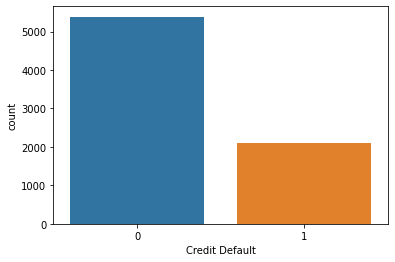

In [6]:
import seaborn as sns
sns.countplot(x='Credit Default', data=df_train)

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [8]:
class Preprocessor:
      #"""Подготовка исходных данных"""
    def __init__(self):
     # """Параметры класса"""
        self.medians = None
        self.years_quantille = None
        self.credit_quantille = None
        self.loan_quantille = None

    def fit(self, df):
        #  """Сохранение статистик""" 
        self.medians = df.median()
        self.years_quantille = np.quantile(df['Years of Credit History'], q=0.95)
        self.credit_quantille = np.quantile(df['Maximum Open Credit'], q=0.95)
        self.loan_quantille = np.quantile(df['Current Loan Amount'], q=0.9)
                                               
    def transform(self, df):
         # """Трансформация данных"""
        
        df.loc[df['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 'Home Mortgage'       
        
        df['Ownership'] = df['Home Ownership'].copy()
        df = pd.get_dummies(df, columns=['Ownership'])
        df.replace({'Home Ownership': {'Own Home': 2, 
                                       'Home Mortgage': 1, 
                                       'Rent': 0}
                    }, inplace=True)
        
        df.replace({'Years in current job': 
                                            {'10+ years': 10,
                                             '9 years': 9, 
                                             '8 years': 8,
                                             '7 years': 7, 
                                             '6 years': 6,
                                             '5 years': 5,
                                             '4 years': 4,
                                             '3 years': 3,
                                             '2 years': 2,
                                             '1 year': 1,
                                             '< 1 year': 0,}}, inplace=True)
        
        self.years_in_cur_job_median = df['Years in current job'].median()
        df['Years in current job'].fillna(self.years_in_cur_job_median, inplace=True)
        
        df.replace({'Purpose': 
                                            {'debt consolidation': 0,
                                             'other': 1, 
                                             'home improvements': 1,
                                             'take a trip': 1, 
                                             'buy a car': 1,
                                             'small business': 2,
                                             'business loan': 2,
                                             'wedding': 1,
                                             'educational expenses': 1,
                                             'buy house': 1,
                                             'medical bills': 1,
                                             'moving': 1,
                                             'major purchase': 1,
                                             'vacation':1,
                                             'renewable energy':1, }}, 
                   inplace=True)
        
        df['Purpose'].fillna(0, inplace=True)
        
        df.replace({'Term': {'Short Term': 0, 
                             'Long Term': 1}}, inplace=True)
        
        df['Months since last delinquent'].fillna(0, inplace=True)
        
        df['Annual Income'].fillna(1, inplace = True)
        
        df['Credit Score'].fillna(1, inplace=True)
        df['Credit Score Outlier'] = 0
        df.loc[df['Credit Score'] > 1000, 'Credit Score Outlier'] = 1
        df.loc[df['Credit Score'] > 1000, 'Credit Score'] = df.loc[df['Credit Score'] > 1000, 'Credit Score'] / 10
        
        df['Bankruptcies'].fillna(0, inplace=True)
        
        df['Years of Credit History'].clip(lower=None, upper=self.years_quantille, inplace=True)
        
  
        
        return df


In [9]:
class FeatureGenerator:
  # """Генерация новых фич"""
    def __init__(self):
        self.median = None
        self.ownership_rating = None
        self.job_years_rating = None
        self.credit_default_score_mode = None
        self.median_loan_by_purpose = None

    def fit(self, df):
        self.medians = df.median()
        self.ownership_rating = df.groupby(['Home Ownership'])['Credit Score'].agg('median').to_dict()
        self.job_years_rating = df.groupby(['Years in current job'])['Credit Score'].agg('median').to_dict()
        self.credit_default_score_mode = df.groupby(['Credit Default'])['Credit Score'].agg(pd.Series.mode)[1]
        self.median_loan_by_purpose = df.groupby(['Purpose'])['Current Loan Amount'].agg('median').to_dict()

    def transform(self, df):
        df['Credit to income ratio'] = np.round((df['Annual Income']/12) / df['Monthly Debt'], 3)
        df.loc[df['Credit to income ratio'] == np.inf, ['Credit to income ratio']] = df['Credit to income ratio'].median()
        
        df['Loan to income ratio'] = np.round((df['Annual Income']/12) / df['Current Loan Amount'], 3)
        df.loc[df['Loan to income ratio'] == np.inf, ['Loan to income ratio']] = df['Loan to income ratio'].median()

        df['Ownership_credit_rating'] = df['Home Ownership'].map(self.ownership_rating)

        df['Years in job rating'] = df['Years in current job'].map(self.job_years_rating)

        df['Credit Default Score Delta'] = abs(df['Credit Score'] - self.credit_default_score_mode)

        df['Loan_by_term'] = df['Purpose'].map(self.median_loan_by_purpose)

        return df

In [10]:
preprocessor = Preprocessor()
preprocessor.fit(df_train)
df_train = preprocessor.transform(df_train)
df_test = preprocessor.transform(df_test)


feature_gen = FeatureGenerator()
feature_gen.fit(df_train)
df_train = feature_gen.transform(df_train)
df_test = feature_gen.transform(df_test)

In [11]:
df_train.isna().sum().sum(), df_test.isna().sum().sum()

(0, 0)

Разобьем все данные на две части - на обучающую выборку X_train и на контрольную X_valid.

In [12]:
X = df_train.drop(target_name, axis=1)
y = df_train[target_name]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True, 
                                                      test_size=0.25, 
                                                      random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((5625, 26), (1875, 26), (5625,), (1875,))

Обучим модель catboost 

In [13]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    
baseline = catb.CatBoostClassifier(iterations=50, 
                                   nan_mode='Min', 
                                   silent=True, 
                                   random_state=42,
                                   learning_rate=0.2,
                                   max_depth=3)



baseline.fit(X_train, y_train, eval_set=(X_valid, y_valid))

y_train_pred = baseline.predict(X_train)
y_valid_pred = baseline.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)


TRAIN

              precision    recall  f1-score   support

           0       0.79      0.98      0.88      4074
           1       0.86      0.31      0.46      1551

    accuracy                           0.80      5625
   macro avg       0.83      0.65      0.67      5625
weighted avg       0.81      0.80      0.76      5625

TEST

              precision    recall  f1-score   support

           0       0.76      0.97      0.86      1313
           1       0.82      0.30      0.43       562

    accuracy                           0.77      1875
   macro avg       0.79      0.63      0.64      1875
weighted avg       0.78      0.77      0.73      1875



важность признаков

In [14]:
feature_importances = pd.DataFrame(zip(X_train.columns, baseline.feature_importances_),
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
19,Credit Score Outlier,36.517122
12,Current Loan Amount,17.906189
21,Loan to income ratio,15.866038
1,Annual Income,10.381710
15,Credit Score,5.811244
24,Credit Default Score Delta,3.948479
11,Term,2.410899
20,Credit to income ratio,1.705937
6,Maximum Open Credit,1.540591
4,Number of Open Accounts,0.774079


Значения на f1 небольшие (0.46 и 0.43). Подберем порог вероятности, чтобы улучшить значение f1.

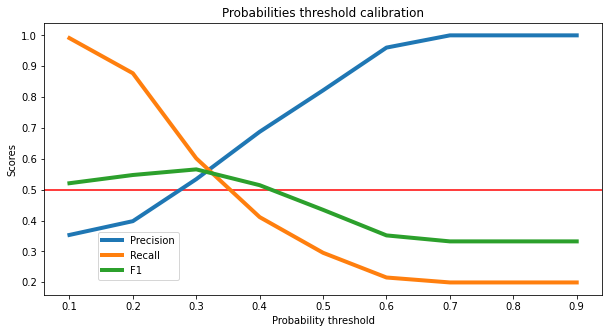

In [15]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
         
    figure = plt.figure(figsize = (10, 5))

    plt1 = figure.add_subplot(111)
    plt1.axhline(0.5, color="red")
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25));
    
y_valid_proba = baseline.predict_proba(X_valid)[:, 1]
show_proba_calibration_plots(y_valid_proba, y_valid)


In [20]:
y_valid_pred = np.array(y_valid_proba > 0.32, dtype=int)
get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.79      0.98      0.88      4074
           1       0.86      0.31      0.46      1551

    accuracy                           0.80      5625
   macro avg       0.83      0.65      0.67      5625
weighted avg       0.81      0.80      0.76      5625

TEST

              precision    recall  f1-score   support

           0       0.81      0.82      0.81      1313
           1       0.57      0.55      0.56       562

    accuracy                           0.74      1875
   macro avg       0.69      0.68      0.69      1875
weighted avg       0.74      0.74      0.74      1875



In [17]:
predictions = baseline.predict(df_test)
predictions = predictions.astype('int32')

 Прогнозирование на тестовом датасете

In [18]:
submit['Credit Default'] = predictions
submit.head()

,Id;Credit Default,Credit Default
0,0;,0
1,1;,0
2,2;,1
3,3;,0
4,4;,0


In [19]:
submit.to_csv('Lukmanova_predictions.csv', index=False)